In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import auto_arima
import emd
from matplotlib import rcParams

In [2]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')

In [4]:
# take only the 50% of the data
df = df[:int(len(df)//2)]

In [5]:
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

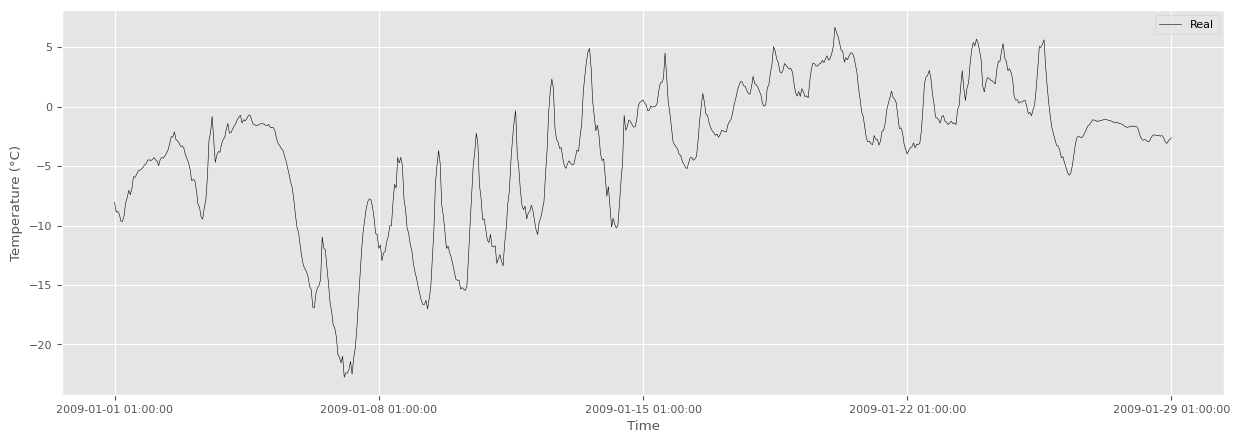

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(time[:673], load[:673], color='k', label='Real', linewidth=0.4)
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

In [7]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

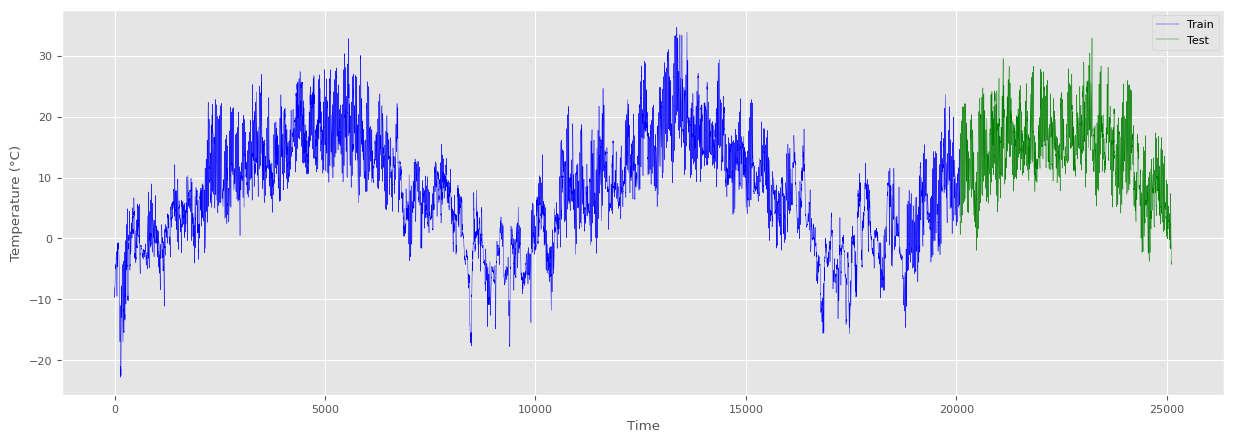

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(train, label='Train', color='b', linewidth=0.3)
plt.plot(test, label='Test', color='g', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

In [9]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])
# display(df_train, df_test)

<Axes: xlabel='Time (samples)'>

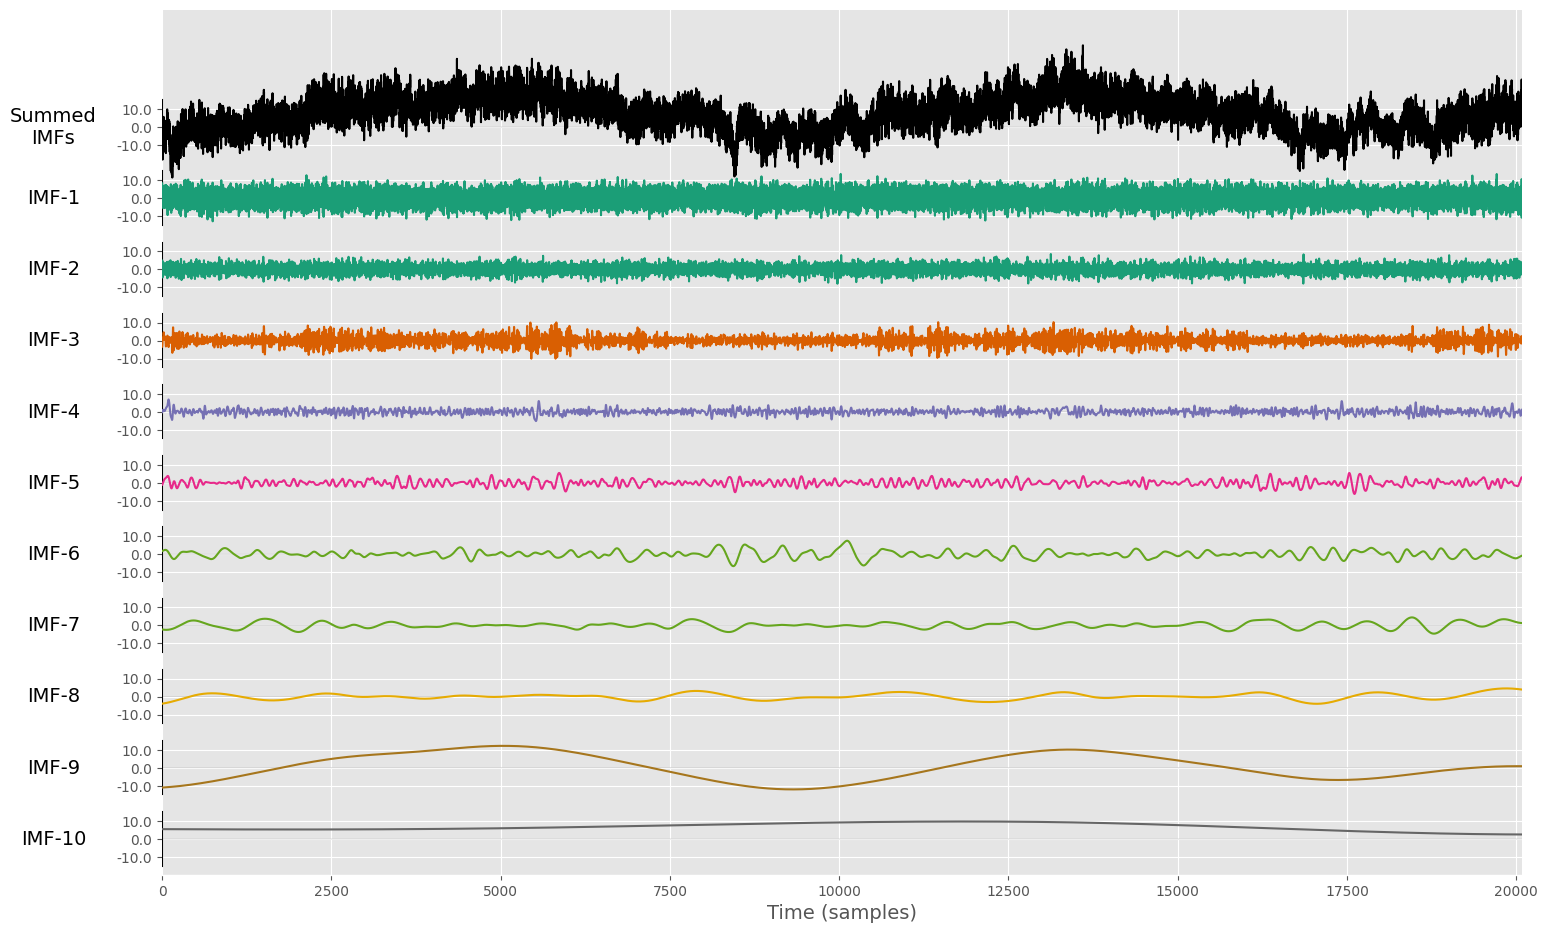

In [10]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,8.260401,4.447676,-3.343771,-0.211487,-0.932695,1.743604,-2.264819,-3.941717,-11.015819,5.477993
1,-5.353950,4.998689,-3.247897,-0.140787,-0.885443,1.757394,-2.272251,-3.936320,-11.013476,5.477806
2,3.224863,4.599980,-2.869010,-0.039630,-0.829548,1.771657,-2.279559,-3.930883,-11.011125,5.477620
3,1.105110,2.055869,-2.245036,0.083183,-0.765620,1.786370,-2.286743,-3.925407,-11.008767,5.477434
4,1.077887,-1.745032,-1.456296,0.219396,-0.694290,1.801508,-2.293804,-3.919892,-11.006401,5.477248
...,...,...,...,...,...,...,...,...,...,...
20084,-0.215782,-0.345032,-0.764976,1.138723,3.205050,-0.829470,1.303073,3.922411,0.875514,2.516717
20085,-3.936597,1.449858,-1.079588,1.218610,3.208356,-0.821322,1.301809,3.917376,0.875174,2.516615
20086,6.725566,1.750876,-1.318136,1.272202,3.205333,-0.813871,1.300678,3.912325,0.874829,2.516515
20087,-7.862697,1.763481,-1.482284,1.298782,3.195950,-0.807119,1.299682,3.907256,0.874480,2.516414


In [12]:
from statsmodels.tsa.arima.model import ARIMA

imf1_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_1'], order=(2, 1, 5)).fit()
imf1_eemd_arima_fc = imf1_eemd_arima.forecast(steps=len(test))

imf2_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_2'], order=(2, 1, 5)).fit()
imf2_eemd_arima_fc = imf2_eemd_arima.forecast(steps=len(test))

imf3_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_3'], order=(2, 1, 5)).fit()
imf3_eemd_arima_fc = imf3_eemd_arima.forecast(steps=len(test))

imf4_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_4'], order=(2, 1, 5)).fit()
imf4_eemd_arima_fc = imf4_eemd_arima.forecast(steps=len(test))

imf5_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_5'], order=(2, 1, 5)).fit()
imf5_eemd_arima_fc = imf5_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [13]:
imf6_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_6'], order=(2, 1, 5)).fit()
imf6_eemd_arima_fc = imf6_eemd_arima.forecast(steps=len(test))

imf7_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_7'], order=(2, 1, 0)).fit()
imf7_eemd_arima_fc = imf7_eemd_arima.forecast(steps=len(test))

imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(2, 1, 0)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(2, 1, 0)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(2, 1, 0)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

# imf11_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_11'], order=(2, 1, 0)).fit()
# imf11_eemd_arima_fc = imf11_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [14]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

In [15]:
imf_eemd_fc = np.sum([imf1_eemd_arima_fc, imf2_eemd_arima_fc, imf3_eemd_arima_fc,
                imf4_eemd_arima_fc, imf5_eemd_arima_fc,imf6_eemd_arima_fc,
                imf7_eemd_arima_fc,imf8_eemd_arima_fc,imf9_eemd_arima_fc, imf10_eemd_arima_fc], axis = 0)

In [16]:
import matplotlib.dates as mdates

df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

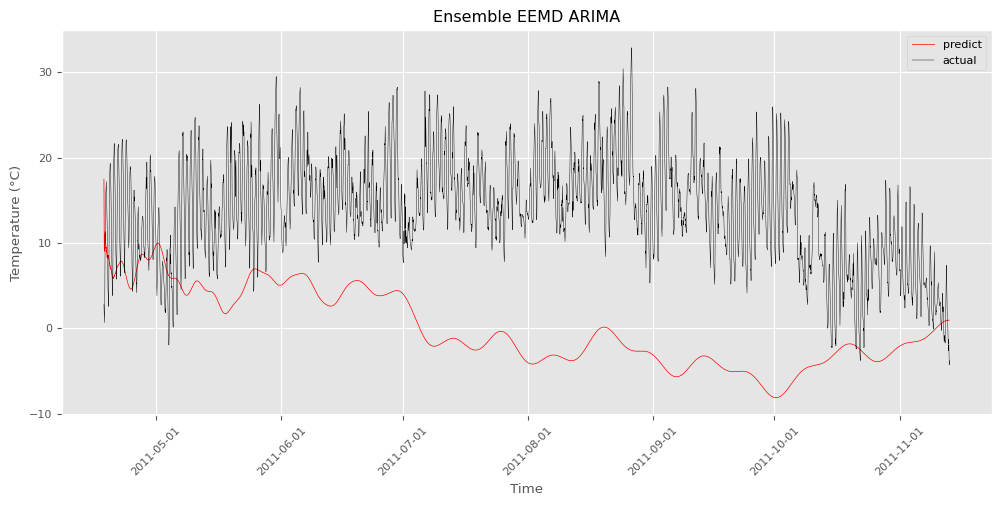

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.title('Ensemble EEMD ARIMA')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

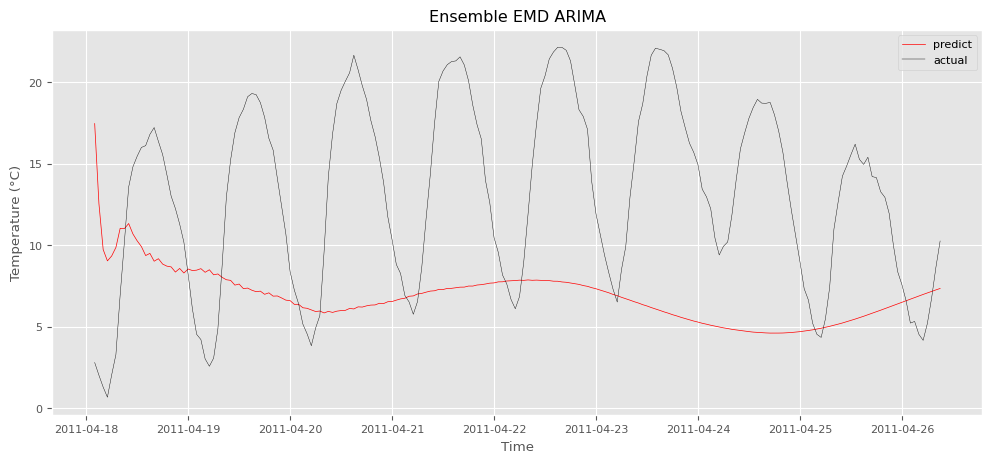

In [26]:
import matplotlib.dates as mdates

test_subset = test[:200]
imf_eemd_fc_subset = imf_eemd_fc[:200]

plt.figure(figsize=(12, 5))
plt.plot(test_subset.index, imf_eemd_fc_subset, label='predict', color='r', linewidth=0.5)
plt.plot(test_subset.index, test_subset.values, label='actual', color='k', linewidth=0.3)
plt.title('Ensemble EMD ARIMA')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()

In [19]:
# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

MAE = 14.193277197500798 
MAPE = 2597009464242.602


In [20]:
# # Definir función de minimización
# def dummy1(c):
#     global test
#     global imf_lstm_fc
#     return mean_squared_error(test, imf_lstm_fc + c)

# # Minimización
# res1 = minimize(dummy1, 0, method='nelder-mead',
#                  options={'xatol': 1e-8, 'disp': True})
# print('Valor óptimo de c:', res1.x)

In [23]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Definir función de minimización
def dummy1(c):
    global test
    global imf_lstm_fc
    return mean_squared_error(test, imf_eemd_fc + c)

# Minimización
res1 = minimize(dummy1, 0, method='nelder-mead',
                 options={'xatol': 1e-8, 'disp': True})

print('Valor óptimo de c:', res1.x)

Optimization terminated successfully.
         Current function value: 56.400477
         Iterations: 45
         Function evaluations: 93
Valor óptimo de c: [13.99765186]


In [24]:
# Ajustar las predicciones con el residuo
imf_eemd_fc_adjusted = imf_eemd_fc + res1.x[0]

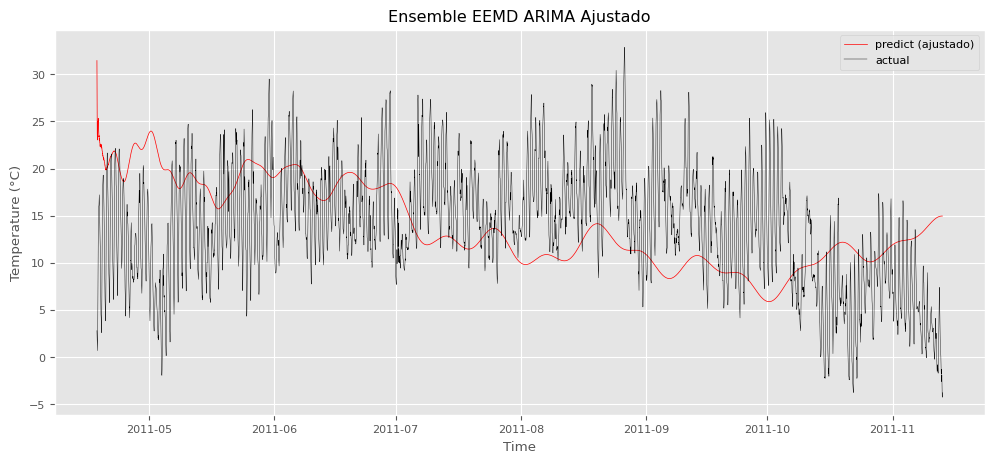

In [25]:
# Graficar predicciones ajustadas
plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc_adjusted, label='predict (ajustado)', color='r', linewidth=0.5)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.title('Ensemble EEMD ARIMA Ajustado')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.show()

In [27]:
# Calcular métricas ajustadas
MAE_EEMD_ARIMA_adjusted = mean_absolute_error(test, imf_eemd_fc_adjusted)
MAPE_EEMD_ARIMA_adjusted = mean_absolute_percentage_error(test, imf_eemd_fc_adjusted)

print('MAE (Ajustado) = {}'.format(MAE_EEMD_ARIMA_adjusted), 
      '\nMAPE (Ajustado) = {}'.format(MAPE_EEMD_ARIMA_adjusted))

MAE (Ajustado) = 6.0738047480167445 
MAPE (Ajustado) = 9953223400651.959
